In [34]:
import pandas as pd
import glob
#!pip install networkx
#!pip install scipy
import networkx as nx
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

### Graph Analysis: Seeing Who Votes Alike

To really understand how Massachusetts politicians align, we'll try to build a "co-vote map". This is a weighted, undirected map. The direction of a vote doesn't inherently define the relationship between two politicians in this context, so an undirected graph makes sense. The weight based on the number of times two politicians voted the same way

In [35]:
votes_df = pd.read_csv("votes.csv")
people_df = pd.read_csv("people.csv")

### Motivation

* Are things truly as straightforward as a two-party system? We want to dig deeper and find the hidden voting blocs that might exist.

* This isn't about predicting how someone will vote (that's classification). Instead, it's like grouping people based on their actual behavior: a clustering problem. We want to see if natural groups emerge from the voting data itself.

* We also might find insights in regards where the breach between the groups are. i.e what differentiates the parties. This might be explored further when we anaylize performance metrics on legistlation.



In [36]:
same_vote_edges = defaultdict(int)

for bill_id, group in votes_df.groupby("bill_id"):
    for vote_type, subgroup in group.groupby("vote_text"):
        voters = list(subgroup["people_id"])
        for a, b in combinations(sorted(voters), 2):
            same_vote_edges[(a, b)] += 1

G_covote = nx.Graph()
G_covote.add_nodes_from(votes_df["people_id"].unique())
for (a, b), weight in same_vote_edges.items():
    if a != b:
        G_covote.add_edge(a, b, weight=weight)

id_to_party = people_df.set_index("people_id")["party"].to_dict()

nx.set_node_attributes(G_covote, id_to_party, name="party")


In [37]:
#this is my mapping fo the colors of the nodes
party_colors = {
    "D": "blue",
    "R": "red",
    "": "gray",
    'I': 'green',
    None: "gray",
    'Unknown': 'gray'
}
node_colors = [
    party_colors.get(G_covote.nodes[n].get("party", ""), "gray")
    for n in G_covote.nodes()
]

G_covote.remove_nodes_from(list(nx.isolates(G_covote)))
id_to_name = people_df.set_index("people_id")["name"].to_dict()
labels = {node: id_to_name.get(node, str(node)) for node in G_covote.nodes}

#### Centrality: The bridges



A high betweenness score suggests a politician frequently acts as an intermediary, potentially playing a vital role in communication, negotiation, and the formation of broader coalitions across different voting blocs.

In [38]:
centrality = nx.betweenness_centrality(G_covote, weight="weight")
node_sizes = [5000 * centrality[n] + 100 for n in G_covote.nodes()]

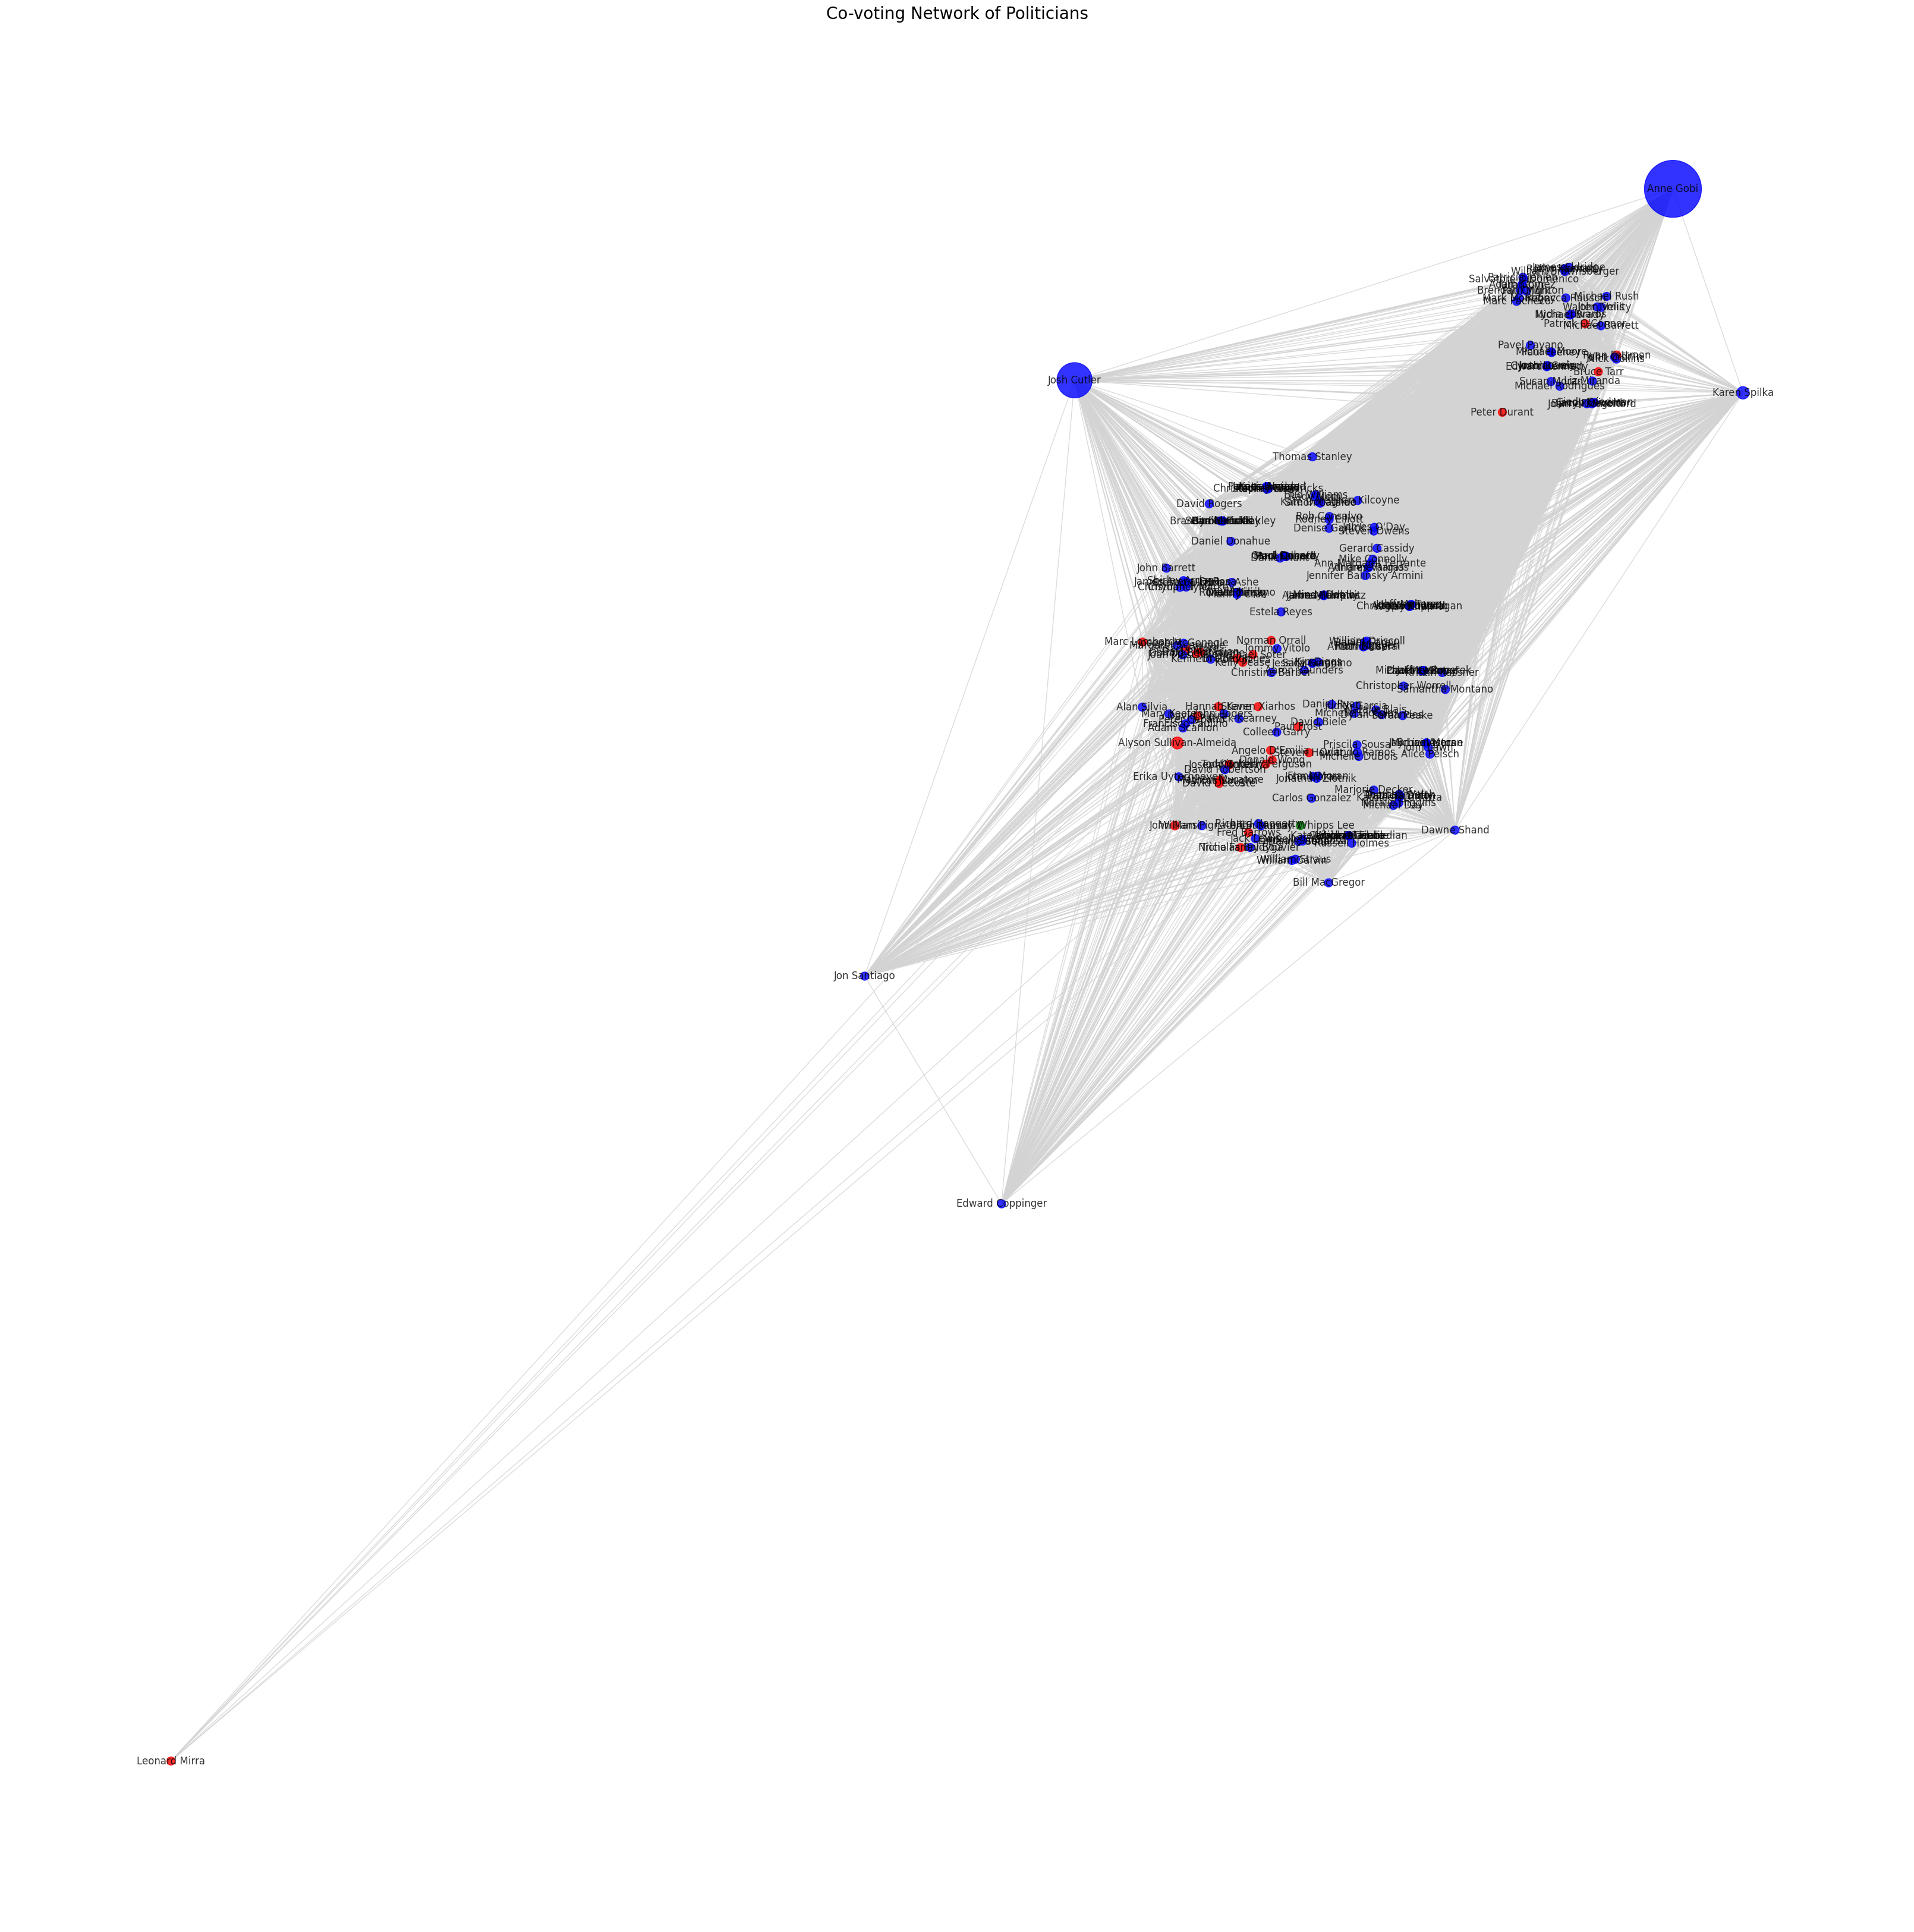

In [39]:
plt.figure(figsize=(32, 32))
pos = nx.spring_layout(G_covote,k=0.3, seed=42,iterations=150)
#, k=0.3, iterations=50
nx.draw(
    G_covote,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    labels=labels,
    with_labels=True,
    edge_color="lightgray",
    alpha=0.8
)
plt.title("Co-voting Network of Politicians", fontsize=20)
plt.show()

Better representation of nodes and edges, using quartiles for defining node size:

In [40]:

centrality_values = list(centrality.values())
q1 = np.percentile(centrality_values, 25)
q2 = np.percentile(centrality_values, 50)
q3 = np.percentile(centrality_values, 75)
min_size = 100
size_multiplier = 900
node_sizes = []
for n in G_covote.nodes():
    centrality_score = centrality[n]
    if centrality_score <= q1:
        node_sizes.append(min_size)
    elif centrality_score <= q2:
        node_sizes.append(min_size + size_multiplier)
    elif centrality_score <= q3:
        node_sizes.append(min_size + 2 * size_multiplier)
    else:
        node_sizes.append(min_size + 3 * size_multiplier)

edge_weights = [data['weight'] for u, v, data in G_covote.edges(data=True)]

ew_q1 = np.percentile(edge_weights, 25)
ew_q2 = np.percentile(edge_weights, 50)
ew_q3 = np.percentile(edge_weights, 75)

edge_colors = []
for u, v, data in G_covote.edges(data=True):
    weight = data['weight']
    if weight <= ew_q1:
        edge_colors.append('lightgray')
    elif weight <= ew_q2:
        edge_colors.append('gray')
    elif weight <= ew_q3:
        edge_colors.append('darkgray')
    else:
        edge_colors.append('black')

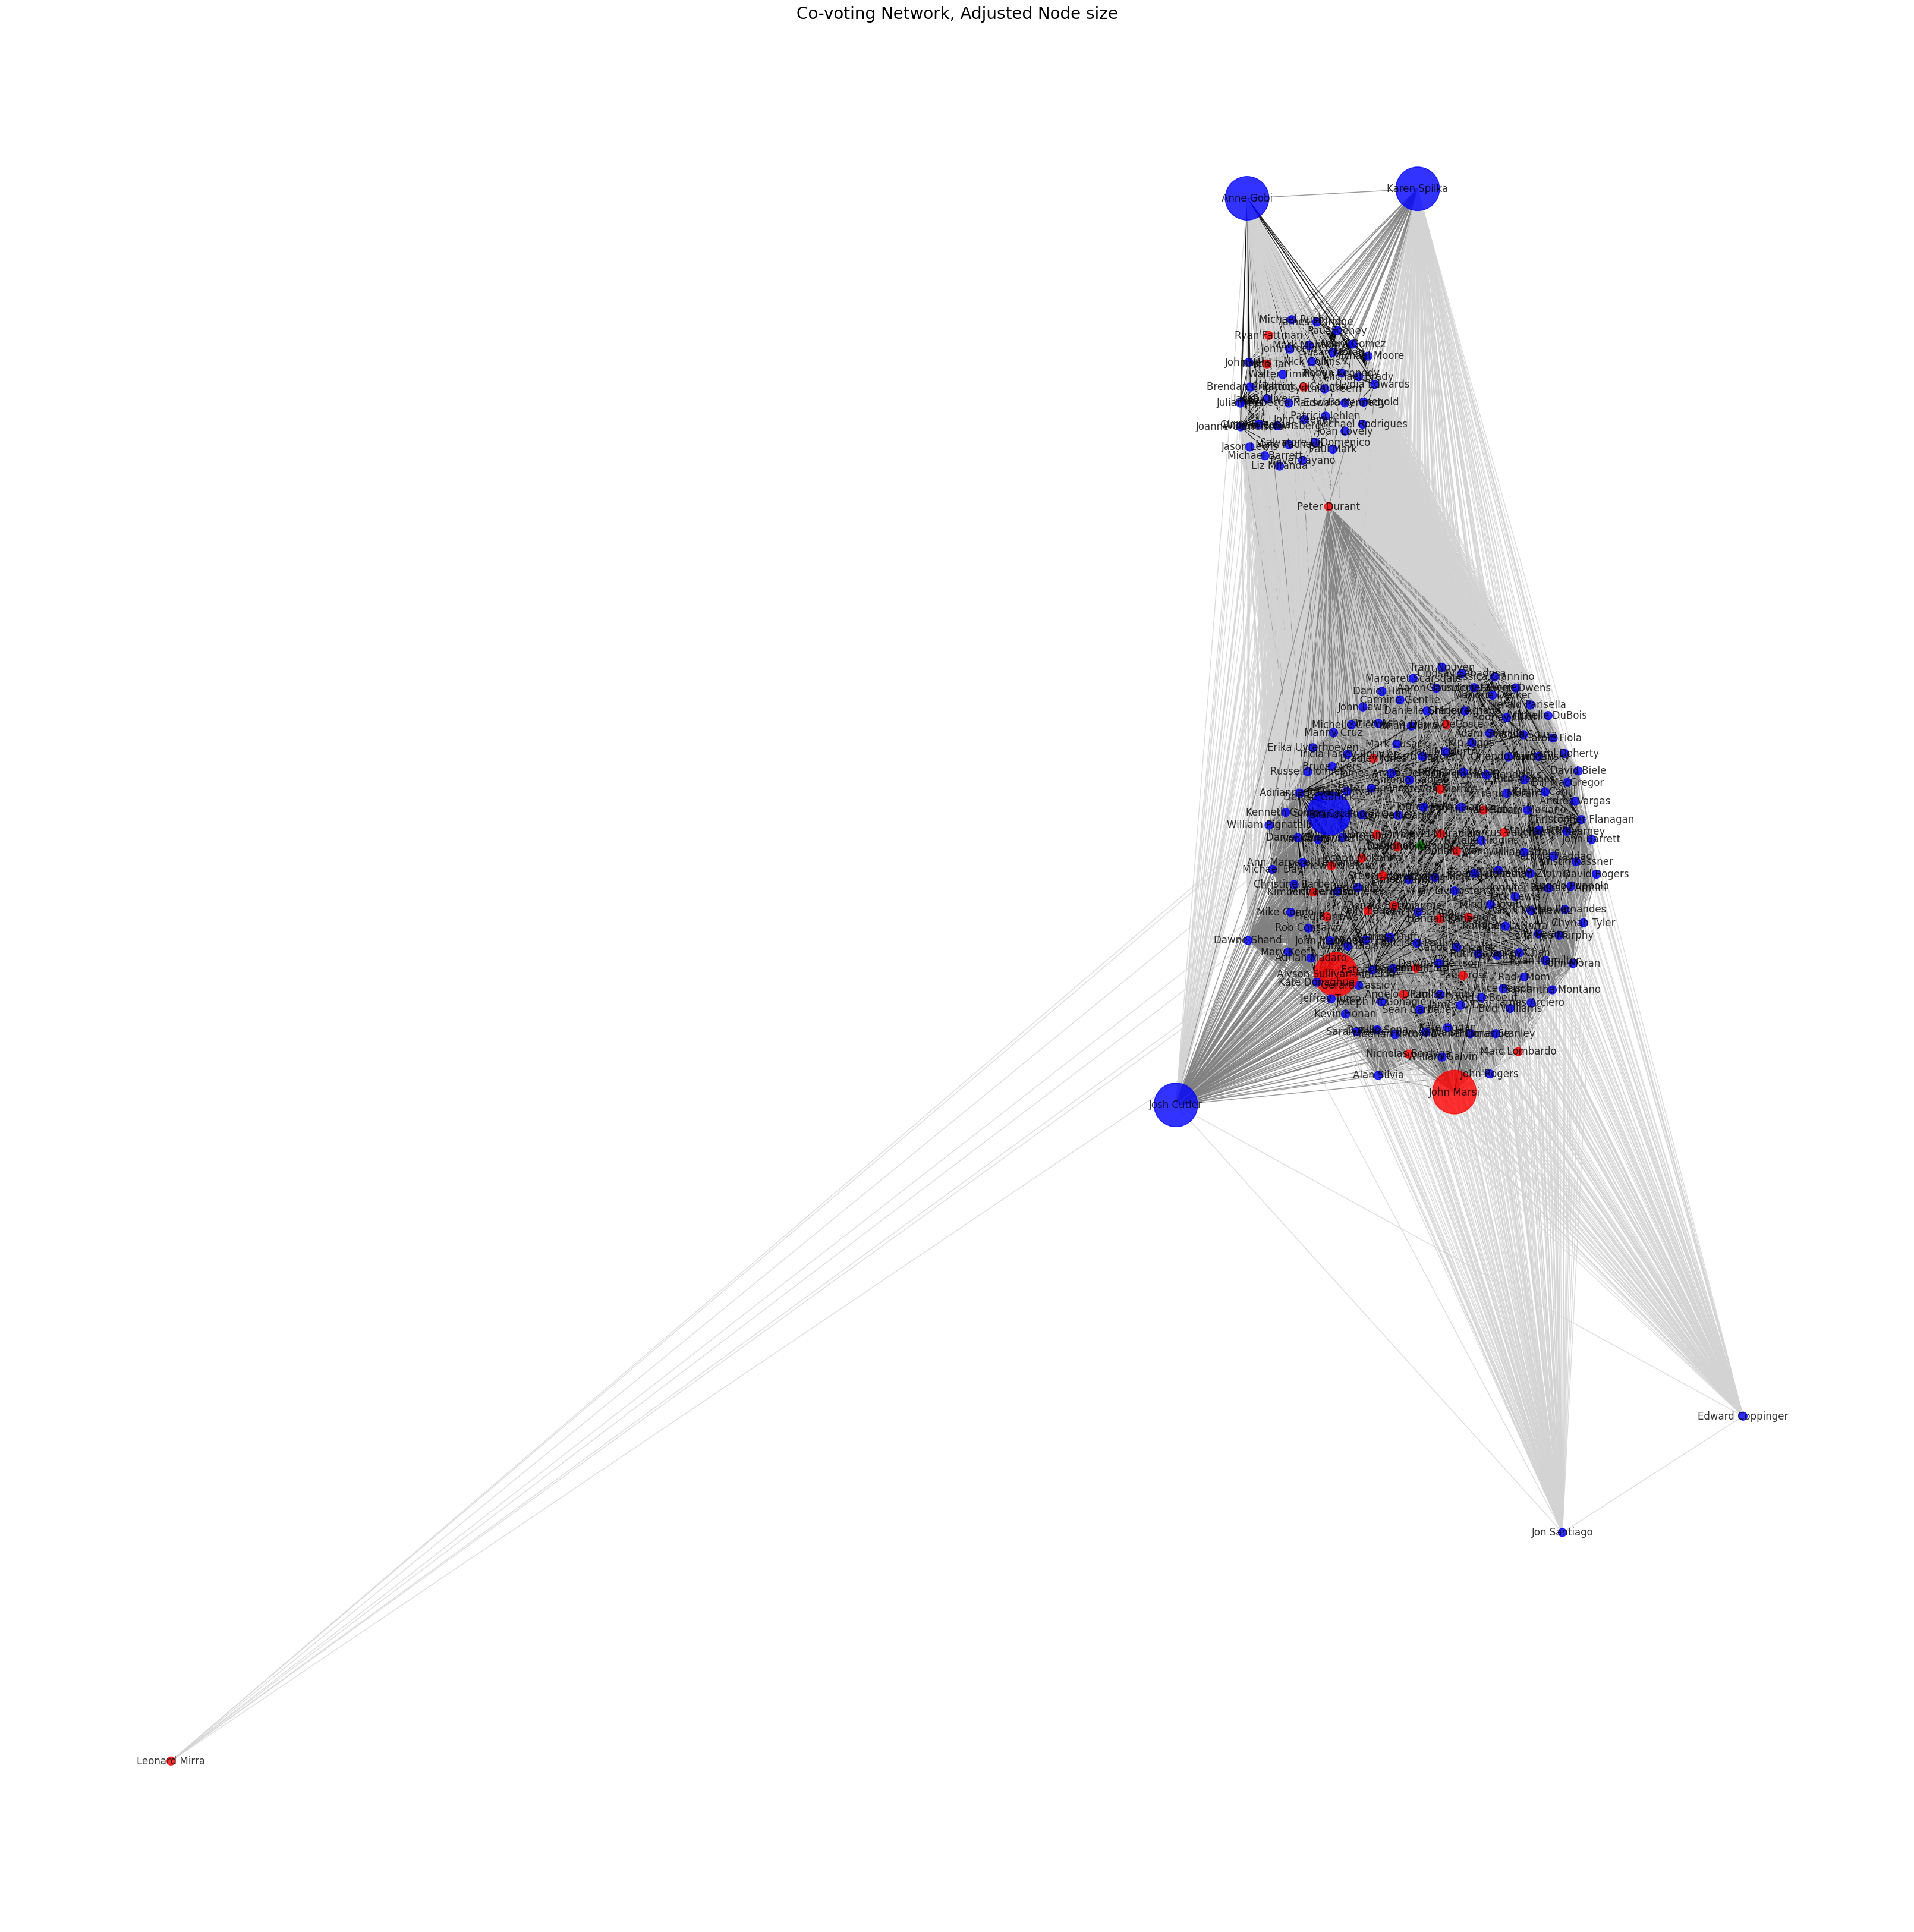

In [41]:
plt.figure(figsize=(32, 32))
pos = nx.spring_layout(G_covote,k=0.8, seed=42,iterations=300)
nx.draw(
    G_covote,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    labels=labels,
    with_labels=True,
    edge_color=edge_colors,
    alpha=0.8
)
plt.title("Co-voting Network, Adjusted Node size", fontsize=20)
plt.show()

In [42]:
centrality_df = pd.DataFrame([{"people_id": node, "betweenness centrality": score} for node, score in centrality.items()])
centrality_df = centrality_df.merge(people_df[["people_id", "name", "party"]],on="people_id",how="left")
centrality_df = centrality_df.sort_values("betweenness centrality", ascending=False).reset_index(drop=True)
centrality_df.head(6)

people_id  betweenness centrality                     name party
0       2445                0.933912                Anne Gobi     D
1      16187                0.344925              Josh Cutler     D
2       2576                0.025460             Karen Spilka     D
3      21148                0.022411  Alyson Sullivan-Almeida     R
4      24757                0.004755            Simon Cataldo     D
5      25189                0.003121               John Marsi     R



Two densely connected clusters emerged, likely representing Democratic legislators based on their strong interconnections.

A peripheral node, Leonard Mirra (Republican), appears to vote differently from the core group, reinforcing the partisan divide.

Anne Gobi and Josh Cutler, both Democrats, occupy central positions within the densest cluster. Their high degree and betweenness centrality indicate that they often vote with many other members, potentially acting as bridges or consensus builders within their party.

This may suggest leadership roles or influence in shaping legislative consensus.

*Temptative analysis if we had more time:* Observe the "gap" between parties across the years to see if polarization occurred. This data is from 2023-2024

#### The Most Influential: Unveiling Agenda-Setters through PageRank Centrality


PageRank centrality identifies the most influential politicians within the network. Unlike simple measures of connectivity, PageRank assigns higher values to politicians who vote with other highly connected peers. These individuals, positioned at the nexus of influential voting patterns, are potential "agenda-setters".

In [43]:
pagerank = nx.pagerank(G_covote, weight='weight')

In [44]:
pagerank_df = pd.DataFrame([{"people_id": node, "pagerank": score} for node, score in pagerank.items()])
pagerank_df = pagerank_df.merge(people_df[["people_id", "name", "party"]],on="people_id",how="left")
pagerank_df = pagerank_df.sort_values("pagerank", ascending=False).reset_index(drop=True)
pagerank_df.head(10)


people_id  pagerank              name party
0       2577  0.006757        Bruce Tarr     R
1       2531  0.006645    Walter Timilty     D
2      17963  0.006641  Patrick O'Connor     R
3       2435  0.006604    Barry Finegold     D
4      16207  0.006527       Joan Lovely     D
5      13110  0.006477         Paul Mark     D
6      17662  0.006471  Brendan Crighton     D
7      19195  0.006471        Julian Cyr     D
8      21064  0.006471  Joanne Comerford     D
9      19410  0.006471    Cindy Friedman     D

Bruce Tarr, a Republican, has the highest page rank, which might suggest he frequently votes alongside key players across the aisle, positioning himself as a connector node.

The next several high-ranking individuals (Timilty, Finegold, Lovely, etc.) are Democrats. This suggests that core influence within the network remains with the Democrats.

Note: Influence != Betweeness, A politician may have high PageRank (importance) without necessarily having high betweenness (bridging role).

* Interesting Facts

Bruce Tarr, the top-ranking node by PageRank, is not just any legislator. He is the Minority Leader of the Massachusetts Senate. His high PageRank score reflects his central role in legislative activity, even as a Republican in a predominantly Democratic legislature. This aligns with the theory behind PageRank: influence is earned not merely by raw connectivity, but by being connected to other well-connected individuals.

#### The Reach of Influence: Katz Centrality

Katz centrality reflects more than popularity. It quantifies a node's influence within a graph by considering both direct and indirect connections. It's essentially a measure of how influential a node is based on its direct neighbors and also those reachable through its neighbors. High Katz scores point to politicians who are structurally significant within the network, potentially indicating a broader sphere of influence than simply their direct ties would suggest, and distinct from the "bridging" role identified by betweenness.

In [45]:
katz = nx.katz_centrality_numpy(G_covote, weight='weight', alpha=0.005)
katz_df = pd.DataFrame([{"people_id": node, "katz": score} for node, score in katz.items()])
katz_df = katz_df.merge(people_df[["people_id", "name", "party"]],on="people_id",how="left")
katz_df = katz_df.sort_values("katz", ascending=False).reset_index(drop=True)
katz_df.head()


people_id      katz              name party
0      13117  0.466399  Edward Coppinger     D
1      21146  0.466399      Jon Santiago     D
2      16187  0.430131       Josh Cutler     D
3      16204  0.364720     Leonard Mirra     R
4       2576  0.316108      Karen Spilka     D

* Interesting Facts

Karen Spilka, who appears in the top 5, coincidentally is the Senate President. This demonstrates how this metric captures the inherent influence associated with leadership roles.

Josh Cutler, whom we already spotted as central, confirms his key position through Katz centrality as well.

Leonard Mirra, despite being a Republican in a largely Democrat network, scores very high. This suggests that while he may not vote identically to many, the subset he aligns with are themselves influential or well-connected. You might remember that Mirra appeared quite distant from the main clusters in our betweenness centrality analysis, highlighting that high Katz centrality doesn't necessarily equate to a bridging role.

Edward Coppinger and Jon Santiago tie for the highest score, suggesting they are embedded in tightly interconnected communities of co-voters.


### Summary


In our betweenness graph, Anne Gobi and Josh Cutler have the highest betweenness centrality, meaning they often serve as "bridges" in the co-voting network. This suggests they vote across cliques or subgroups, positioning them as crucial players in potential coalition-building and bipartisan interactions. They act as key influencers by linking otherwise separate voting factions.


Next, we analyzed PageRank centrality. While betweenness centrality highlighted politicians who bridge different voting groups, PageRank centrality focuses on a different aspect of influence: the importance of a node based on the importance of its connections.

Our results show that Bruce Tarr, the Republican Minority Leader in the Massachusetts Senate, ranks highest in PageRank. This aligns with his leadership role. Despite being in the minority party, he remains central in the network, indicating he votes on many bills with widespread support and maintains ties across political lines.

Other high PageRank politicians, such as Walter Timilty and Patrick O'Connor, also appear to be consistently involved in broadly-supported legislation, making them influential not just within their party, but across the legislative body.

Lastly, we examined Katz centrality, which builds on degree centrality but gives additional weight to being connected to influential individuals. In this sense, it doesn't just matter how many connections a politician has, it matters who they’re connected to.

Interestingly, the top Katz scores were not the same as in PageRank. For example, Edward Coppinger and Jon Santiago, both Democrats, ranked highest. This suggests they are embedded in tightly knit and influential circles, even if they aren't the most central or bridging figures in the network.

### How does this relate to the project?


Our project is focused on transparency and informing the public. As someone who isn’t deeply familiar with American politics, or even from the U.S., the graph still provides a meaningful snapshot of how Massachusetts politicians align in their voting behavior.

Think of our politician co-voting graph like a map of who's working with whom in Massachusetts. You don't need to know every single politician to get a sense of the landscape.

By using network analysis, we can surface patterns of influence, cooperation, and division. A whole story is compressed, and might be displayed on the frontend, suddenly a user might know a whole lot about the state, namely who is important in massachussets, and how they vote.


Imagine seeing this map online:

* The Popular Players: Politicians with high PageRank are like the well-connected hubs, like the republican Bruce Tar for Massachusetts.

* The Connectors: Those with high betweenness, like Anne Gobi and Josh Cutler, are like bridges. They make deals happen.

* The Influential Groups: Katz centrality helps us see who's tight with other important people. like Democrats Edward Coppinger and Jon Santiago seem to be.


Basically, we're taking the records and turning them into a visual story.

Someone in Massachusetts, or elsewhere, could see this graph and quickly get a sense of who the key players.  It's like getting the cheat sheet to understand who's important, without having to read hundreds of bills.